In [9]:
import csv
import re

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [11]:
from collections import defaultdict

In [12]:
exon_orth = defaultdict(lambda: defaultdict(dict))

In [13]:
with open("../data/homology/exons/exons.csv", 'r') as f:
    reader = csv.DictReader(f)

    for row in reader:
        hsap_type, hsap_exon = row.pop('hsap_exon').split("=")

        hsap_gene = row.pop('hsap_gene')
        hsap_func = row.pop('hsap_gene_biotype')

        if hsap_func != "protein_coding":
            continue

        chrom, *pos = re.split('[:-]', hsap_exon)
        beg, end, strand = map(int, pos)

        hsap_exon = f"{chrom}:{beg}-{end}:{strand}"
        exon_orth[hsap_exon]['homo_sapiens'] = hsap_type

        for name, exon in row.items():
            if exon == "-":
                exon_orth[hsap_exon][name] = "N"
            else:
                exon_type, _ = exon.split("=")
                exon_orth[hsap_exon][name] = exon_type

In [14]:
exon_gain = {
    'FE': {'N': 0, 't': 0},
    'IE': {'N': 0, 't': 0},
    'LE': {'N': 0, 't': 0}
}

In [15]:
with open("../data/homology/ss/out/origin.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)

    for row in reader:
        gene, meta_exon, p, ss, _, gain_ages, loss_ages, pos_group, neg_group, tree_size, _ = row

        if ";" in gain_ages or int(tree_size) < 3:
            # `";" in gain_ages` indicates more than one gain event, which
            # we've opted to exclude.
            continue

        exon_type, exon = meta_exon.split("=")
        if exon not in exon_orth \
                or exon_type not in ["FE", "IE", "LE"]:
            continue

        pos_group = pos_group.split(";")
        neg_group = neg_group.split(";")

        pos_types = set([exon_orth[exon][name] for name in pos_group]) - {'N'}
        neg_types = set([exon_orth[exon][name] for name in neg_group]) - {'N'}

        # If `exon in exon_orth`, we also know the exon had an alignment in 1+
        # species, so we're not counting cases where there's not homolog in
        # the negative group because the human exon failed to align.
        if len(neg_types) == 0:
            exon_gain[exon_type]['N'] += 1
        exon_gain[exon_type]['t'] += 1

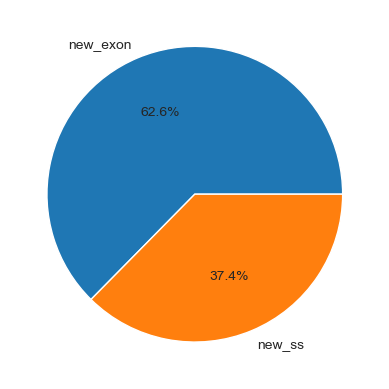

In [16]:
for char, exon_type in zip("def", exon_gain):
    p = exon_gain[exon_type]['N'] / exon_gain[exon_type]['t'] * 100
    plt.clf()

    _ = plt.pie([p, 100 - p], labels=['new_exon', 'new_ss'], autopct='%1.1f%%')
    plt.savefig(f"figs/supp2{char}_{exon_type}.pdf")